In [1]:
import pickle

import pandas as pd
from helpers import *

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import tensorflow as tf

In [2]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == labels) / predictions.shape[0])

## Load dataset

In [3]:
with open('../data/prepared_data.pickle', 'rb') as data:
    data_dic = pickle.load(data)

In [4]:
train = data_dic['sample_df']['train']
test  = data_dic['sample_df']['test']
valid = data_dic['sample_df']['valid']

In [5]:
train_dataset = np.array(train.sentence_vecs.tolist())
test_dataset  = np.array(test.sentence_vecs.tolist())
valid_dataset = np.array(valid.sentence_vecs.tolist())

In [6]:
train_labels = np.array(train.negative.tolist())
test_labels  = np.array(test.negative.tolist())
valid_labels = np.array(valid.negative.tolist())

In [7]:
vocab_len = len(data_dic['sample_df']['vocab'])

In [8]:
print ("Size of train set: %s" % len(train_dataset))
print ("Size of test set: %s" % len(test_dataset))
print ("Size of validation set: %s" % len(valid_dataset))

Size of train set: 140000
Size of test set: 40200
Size of validation set: 19800


In [9]:
train_dataset, train_labels

(array([[80513, 10752, 70330, ...,  2641,  2641,  2641],
        [53607,  7892, 52677, ...,  2641,  2641,  2641],
        [26034,  2692, 12524, ...,  2641,  2641,  2641],
        ..., 
        [45219,  4862, 74430, ...,  2641,  2641,  2641],
        [45219, 41892, 37713, ...,  2641,  2641,  2641],
        [25350, 48189, 45219, ...,  2641,  2641,  2641]]),
 array([0, 0, 0, ..., 0, 0, 0]))

## Ready for tensorflow!

In [10]:
SEQ_LENGTH = 100
BATCH_SIZE = 50
NUM_LABELS = 2

VOCAB_SIZE = vocab_len
EMBED_SIZE = 128

FILTER_SIZE_1 = 3
FILTER_SIZE_2 = 4
FILTER_SIZE_3 = 5
NUM_FILTERS = 128

keep_prob = 0.8
l2_reg_lambda=0.001

tf_train_dataset = tf.placeholder(tf.int32, shape=(BATCH_SIZE, SEQ_LENGTH), name="input_x")
tf_train_labels = tf.placeholder(tf.int32, shape=(BATCH_SIZE), name="input_y")
tf_valid_dataset = tf.constant(valid_dataset) 
tf_test_dataset = tf.constant(test_dataset)

# Keeping track of l2 regularization loss (optional)
l2_loss = tf.constant(0.0)

## Embedding layer

embed_weigths = tf.Variable(tf.random_uniform([VOCAB_SIZE, EMBED_SIZE], -1.0, 1.0))
    
## Convolutional layers
## Change to True if run again
with tf.variable_scope("vars", reuse = None):
    
    conv1_weights = tf.get_variable("conv1_w", shape=[FILTER_SIZE_1, EMBED_SIZE, 1, NUM_FILTERS],\
                                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv1_biases = tf.Variable(tf.constant(0.1, shape=[NUM_FILTERS]), name = "conv1_b")

    conv2_weights = tf.get_variable("conv2_w", shape=[FILTER_SIZE_2, EMBED_SIZE, 1, NUM_FILTERS],\
                                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv2_biases = tf.Variable(tf.constant(0.1, shape=[NUM_FILTERS]), name = "conv2_b")

    conv3_weights = tf.get_variable("conv3_w", shape=[FILTER_SIZE_3, EMBED_SIZE, 1, NUM_FILTERS],\
                                                    initializer=tf.contrib.layers.xavier_initializer_conv2d())
    conv3_biases = tf.Variable(tf.constant(0.1, shape=[NUM_FILTERS]), name = "conv3_b")

## Fully connected layer

    fc1_weights = tf.get_variable("fc1_w", shape=[3*NUM_FILTERS, NUM_LABELS],\
                                                initializer=tf.contrib.layers.xavier_initializer())
    fc1_biases = tf.Variable(tf.constant(0.1, shape=[NUM_LABELS]), name = "fc1_b")

# Model:
def model(data, keep_prob = keep_prob): 
    
    ## Embedding layer
    ## input shape:[BATCH_SIZE, SEQ_LENGTH]
    ## output shape: [BATCH_SIZE, SEQ_LENGTH, EMBED_SIZE, 1]
    
    with tf.device('/cpu:0'), tf.name_scope("word2vec_embedding"):    
        embed_chars = tf.nn.embedding_lookup(embed_weigths, data)
        embed_chars = tf.expand_dims(embed_chars, -1)
    
    ## Conv1+ReLu+max pooling
    ## input shape: [BATCH_SIZE, SEQ_LENGTH, EMBED_SIZE, 1]
    ## output shape: [BATCH_SIZE, 1, 1, NUM_FILTERS]
    
    with tf.name_scope("conv1-maxpool-3"):
        conv1 = tf.nn.conv2d(embed_chars, conv1_weights, strides=[1, 1, 1, 1], padding="VALID")
        relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_biases))
        pool1 = tf.nn.max_pool(relu1, ksize=[1, SEQ_LENGTH-FILTER_SIZE_1+1, 1, 1],
                               strides=[1, 1, 1, 1], padding='VALID')
    ## Conv2+ReLu+max pooling
    ## input shape: [BATCH_SIZE, SEQ_LENGTH, EMBED_SIZE, 1]
    ## output shape: [BATCH_SIZE, 1, 1, NUM_FILTERS]
    
    with tf.name_scope("conv2-maxpool-4"):
        conv2 = tf.nn.conv2d(embed_chars, conv2_weights, strides=[1, 1, 1, 1], padding="VALID")
        relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_biases))
        pool2 = tf.nn.max_pool(relu2, ksize=[1, SEQ_LENGTH-FILTER_SIZE_2+1, 1, 1],
                               strides=[1, 1, 1, 1], padding='VALID')
    
    ## Conv3+ReLu+max pooling
    ## input shape: [BATCH_SIZE, SEQ_LENGTH, EMBED_SIZE, 1]
    ## output shape: [BATCH_SIZE, 1, 1, NUM_FILTERS]
    
    with tf.name_scope("conv3-maxpool-5"):
        conv3 = tf.nn.conv2d(embed_chars, conv3_weights, strides=[1, 1, 1, 1], padding="VALID")
        relu3 = tf.nn.relu(tf.nn.bias_add(conv3, conv3_biases))
        pool3 = tf.nn.max_pool(relu3, ksize=[1, SEQ_LENGTH-FILTER_SIZE_3+1, 1, 1],
                               strides=[1, 1, 1, 1], padding='VALID')
    
    ## Combine pooled features + flatten
    ## input shape: [BATCH_SIZE, 1, 1, NUM_FILTERS]
    ## output shape: [BATCH_SIZE, 3, 1, 1, NUM_FILTERS]
    
    with tf.name_scope("combine_flatten"):
        pooled_outputs = [pool1, pool2, pool3]
        h_pool = tf.concat(pooled_outputs,3)
        h_pool_flat = tf.reshape(h_pool, [-1, NUM_FILTERS*3])
    
    with tf.name_scope("dropout"):
        h_pool_flat = tf.nn.dropout(h_pool_flat, keep_prob)
    
    ## Fully connected layer
    with tf.name_scope("output"):
        return tf.matmul(h_pool_flat, fc1_weights) + fc1_biases  
  
#Training computation:
logits = model(tf_train_dataset)
with tf.name_scope("loss"):
    l2_loss += tf.nn.l2_loss(fc1_weights)
    l2_loss += tf.nn.l2_loss(fc1_biases)
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=tf_train_labels)) 
    + l2_reg_lambda * l2_loss
  
# Optimizer:
optimizer = tf.train.GradientDescentOptimizer(0.01).minimize(loss)

#saver = tf.train.Saver()

**Predictions for the training, validation, and test data**

In [11]:
train_prediction = tf.nn.softmax(logits)
valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
test_prediction = tf.nn.softmax(model(tf_test_dataset))

## Train model and report accuracy

In [12]:
NUM_ITERATIONS =100001

step = []
pred = []
loss_minibatch = []
accuracy_minibatch = []
accuracy_valid = []
f1_minibatch = []
f1_valid = []

logs_path = '../tensorflow_logs/example_sentiment'

with tf.Session() as session:
    tf.global_variables_initializer().run()
    
    # op to write logs to Tensorboard
    summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())
    
    for i in range(NUM_ITERATIONS):
        offset = (i * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
        batch_data = train_dataset[offset:(offset + BATCH_SIZE), :]
        batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict) 
        
        if (i % 200 == 0):
            step.append(i)
            print("Minibatch loss at step %d: %f" % (i, l))
            loss_minibatch.append(l)
            print("Minibatch accuracy: %.1f%%" % (100*accuracy_score(np.argmax(predictions, 1), batch_labels)))
            accuracy_minibatch.append((100*accuracy_score(np.argmax(predictions, 1), batch_labels)))
            print("Minibatch f1 score: %.1f" % (100*f1_score(np.argmax(predictions, 1), batch_labels)))
            f1_minibatch.append((100*f1_score(np.argmax(predictions, 1), batch_labels)))
            print('Validation accuracy: %.1f%%' % (100*accuracy_score(np.argmax(valid_prediction.eval(),1),
                                                                 valid_labels))) 
            accuracy_valid.append((100*accuracy_score(np.argmax(valid_prediction.eval(),1), valid_labels)))
            print('Validation f1 score: %.1f' % (100*f1_score(np.argmax(valid_prediction.eval(),1),
                                                                 valid_labels)))   
            f1_valid.append((100*f1_score(np.argmax(valid_prediction.eval(),1), valid_labels)))
            
    print("\nTest accuracy: %.1f%%" % (100*accuracy_score(np.argmax(test_prediction.eval(),1), test_labels)))
    print("\nTest f1 score: %.1f" % (100*f1_score(np.argmax(test_prediction.eval(),1), test_labels)))
    
    #save_path = saver.save(session, "../models/sentiment_cnn.ckpt")
    #print("Model saved in file: %s" % save_path)
    
    pred.append(np.argmax(test_prediction.eval(), 1))
    
    print("Run the command line:\n" \
          "--> tensorboard --logdir=path_to_logs/tensorflow_logs " \
          "\nThen open http://172.26.179.29:6006/ into your web browser")
    
pred = pred[0]

Minibatch loss at step 0: 0.903002
Minibatch accuracy: 12.0%
Minibatch f1 score: 18.5
Validation accuracy: 59.5%
Validation f1 score: 22.8
Minibatch loss at step 200: 0.406982
Minibatch accuracy: 84.0%
Minibatch f1 score: 20.0
Validation accuracy: 83.6%
Validation f1 score: 1.6
Minibatch loss at step 400: 0.273504
Minibatch accuracy: 88.0%
Minibatch f1 score: 0.0


/usr/local/lib/python3.5/dist-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Validation accuracy: 84.3%
Validation f1 score: 13.5
Minibatch loss at step 600: 0.379999
Minibatch accuracy: 84.0%
Minibatch f1 score: 20.0
Validation accuracy: 85.1%
Validation f1 score: 22.3
Minibatch loss at step 800: 0.373713
Minibatch accuracy: 84.0%
Minibatch f1 score: 33.3
Validation accuracy: 85.9%
Validation f1 score: 31.2
Minibatch loss at step 1000: 0.283766
Minibatch accuracy: 90.0%
Minibatch f1 score: 61.5
Validation accuracy: 86.3%
Validation f1 score: 34.4
Minibatch loss at step 1200: 0.478527
Minibatch accuracy: 72.0%
Minibatch f1 score: 12.5
Validation accuracy: 87.1%
Validation f1 score: 48.7
Minibatch loss at step 1400: 0.422005
Minibatch accuracy: 86.0%
Minibatch f1 score: 46.2
Validation accuracy: 87.1%
Validation f1 score: 44.1
Minibatch loss at step 1600: 0.315465
Minibatch accuracy: 88.0%
Minibatch f1 score: 40.0
Validation accuracy: 87.6%
Validation f1 score: 50.8
Minibatch loss at step 1800: 0.632525
Minibatch accuracy: 70.0%
Minibatch f1 score: 0.0
Validatio

In [14]:
confusion_matrix(pred,test_labels)

array([[32460,  1823],
       [ 1197,  4720]])

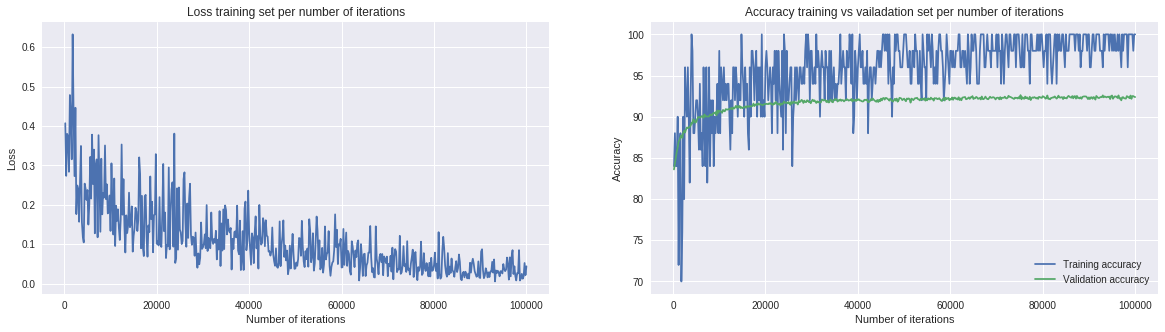

In [15]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(step[1:len(step)],loss_minibatch[1:len(step)])
plt.xlabel('Number of iterations')
plt.ylabel('Loss')
plt.title('Loss training set per number of iterations')

plt.subplot(1, 2, 2)
plt.plot(step[1:len(step)],accuracy_minibatch[1:len(step)], label = 'Training accuracy')
plt.plot(step[1:len(step)],accuracy_valid[1:len(step)], label = 'Validation accuracy')
plt.legend(loc = 0)
plt.xlabel('Number of iterations')
plt.ylabel('Accuracy')
plt.title('Accuracy training vs vailadation set per number of iterations')